Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your github nickname below:

In [110]:
NICKNAME = "agentWSS"

---

# Часть 1. Гауссовы квадратуры

Метод Гауссовых квадратур является одним из методов численного интегрирования, который позволяет увеличить точность интегрирования, используя ортогональные полиномы и их корни в качестве узлов.

$$
\int_a^b \!  w(x)\, f(x)\, dx \approx \sum_{k=1}^n w_k \, f(x_k) \;,
$$

здесь $\omega$ - функция весов, которая определят базис ортогональных полиномов, чьи корни используются в качестве узлов интегрирования. 

Получаемая таким образом квадратурная схема *точно* инегрирует $f(x)$ если это полином степени $m\le2n-1$, где $n$ - степень полинома, корни которого используются в качестве узлов.

## Двухточечная квадратура Гаусса

Постройте квадратурную формулу Гаусса, интегрирующую точно многочлены степеней вплоть до третьей на интервале $[a, b]$. Заметим, что для этого достаточно построить _двухточечную_ квадратуру.

    hint:Легко найти точки и веса для отрезка [-1,1], после чего можно сделать аффинное преобразование..

Напишите функцию, которая возвращает веса, $w_1$ и $w_2$, и узлы, $x_1$ и $x_2$, двухточечной квадратурной формулы Гаусса с весовой функцией $w(x) = 1$, т.е., интегралы вида

$$
\int_a^b\! f(x)\, dx \approx w_1 f(x_1) + w_2 f(x_2)
$$

In [92]:
from scipy.special import roots_legendre

def gauss_2(a, b):
    r"""Return nodes and weights for a two-point Gauss quadrature on [a, b].
    
    Parameters
    ----------
    a, b : float
       Boundaries of the integration interval
       
    Returns
    -------
    x1, x2, w1, w2 : float
       Nodes and weights of the quadrature.
    """
    nodes, weights = roots_legendre(2)
    x1 = (a + b) / 2 + (b - a) / 2 * nodes[0]
    x2 = (a + b) / 2 + (b - a) / 2 * nodes[1]
    w1 = (b - a) / 2 * weights[0]
    w2 = (b - a) / 2 * weights[1]
    return x1, x2, w1, w2

In [93]:
from numpy.testing import assert_allclose

x1, x2, w1, w2 = gauss_2(0, 1)

def f(x, n): 
    return x**n

for n in [0, 1, 2, 3]:
    assert_allclose(w1*f(x1, n=n) + w2*f(x2, n=n),
                    1./(n+1), atol=1e-14)

## Использование ортогональных полиномов

### Legendre

Теперь посчитаем следующий интеграл:

$$
\int_{-1}^1 (7x^3 - 8 x^2 - 3 x + 3) dx  \label{eq1}\tag{1}
$$

Здесь функция уже полиномиальна, поэтому возьмем весовую функцию $\omega(x) = 1$. Тогда вычисление интеграла сводится к сумме корней полинома, соответствующих весовой функции $\omega(x) = 1$. Например, здесь https://dlmf.nist.gov/18.3 вы можете увидеть, какой базис полиномов соответствует вашей весовой функции.

Заметим, что нашей соответствуют полиномы Лежандра. Теперь, зайдем в документацию https://docs.scipy.org/doc/scipy/reference/special.html#orthogonal-polynomials. Функция *roots_legendre* сразу же выдаст корни полиномов Лежандра, а также веса к их корням (для полиномов Лежандра все эти веса равны единице).

1. Посчитайте точное значение интеграла ([1](#mjx-eqn-eq1)) "руками".

In [94]:
func = lambda x: 7 * x**3 - 8 * x**2 - 3 * x + 3
primitive = lambda x: 7 / 4 * x**4 - 8 / 3 * x**3 - 3 / 2 * x**2 + 3 * x
real_int = primitive(1) - primitive(-1)
print(real_int)

0.6666666666666674


2. Посчитайте значение интеграла ([1](#mjx-eqn-eq1)), используя обычный метод интегрирования на равномерной сетке (например, написанный вами в предыдущем дз). Оцените количество узлов, необходимых для достижения относительной точности $10^{-10}$.

In [95]:
def midpoint_rule(func, a, b, eps, real_int):
    """ Вычисляет интеграл f от a до b используя правило центральной точки.
    
    Parameters
    ----------
    func : callable
        Функция, которую нужно проинтегрировать
    a : float
        Нижний предел интегрирования
    b : float
        Верхний предел интегрирования
    eps : float
        Ожидаемая ошибка оценки
        
    Returns
    -------
    integral : float
        Оценка интеграла $\int_a^b f(x) dx$.
    n : int
        The number of intervals on segment.
    """
    
    n = 1 
    integral = func((a + b) / 2) * (b - a)

    while abs(integral - real_int) >= eps:
        integral = 0
        n *= 2
        h = (b - a) / n
        for i in range(1, n + 1):
            integral += func(a + (i - 0.5) * h) * h

    return integral, n

  
midpoint_int, midpoint_n = midpoint_rule(func, -1, 1, 1e-10, real_int)
print(midpoint_int, midpoint_n)

0.6666666667442743 262144


3. Посчитайте значение интеграла ([1](#mjx-eqn-eq1)), с помощью Гауссовой квадратуры (используя корни полинома Лежандра степени от 1 до 6 в качестве узлов) (чтобы получить корни и веса используйте scipy.special.roots_legendre)

In [96]:
import numpy as np

for i in range(1, 7):
    roots, weights = roots_legendre(i)
    print(i, np.sum(func(roots) * weights))

1 6.0
2 0.6666666666666674
3 0.6666666666666639
4 0.6666666666666667
5 0.6666666666666685
6 0.6666666666666695


Сравните количество узлов, необходимых для достижения одинаковой точности в обоих чисенных методах.

In [97]:
for eps in np.logspace(-1, -7, num=10):
  for i in range(1, 10):
    roots, weights = roots_legendre(i)
    if abs(np.sum(func(roots) * weights) - real_int) < eps:
      print(i, end=' ')
      break
  print(midpoint_rule(func, -1, 1, eps, real_int)[1])

2 8
2 16
2 64
2 128
2 256
2 512
2 1024
2 2048
2 4096
2 8192



Вычислите значение того же интеграла, но на интервале от 0 до 10.

$$
\int_{0}^{10} (7x^3 - 8 x^2 - 3 x + 3) dx 
$$

Заметим, что больше нельзя использовать полиномы Лежанда, потому что они определены на интервале (-1, 1). Однако всегда можно произвести *аффинное преобразование* для того, чтобы перейти к желаемой системе координат.

(20% итоговой оценки)

$$
\int_{0}^{10} (7x^3 - 8 x^2 - 3 x + 3) dx = //y=\frac{x}{10}\Rightarrow x=10y//=10\int_{0}^{1} (7\cdot(10y)^3 -8\cdot(10y)^2 - 3\cdot10y + 3) dy
$$

In [98]:
roots, weights = roots_legendre(6)
x = 5 * roots + 5
integral = 5 * np.sum(func(x)*weights)
print(integral)

14713.333333333336


Сравните результат с точным значением интеграла.

In [99]:
real_int = primitive(10) - primitive(0)
print(abs(integral - real_int))

1.8189894035458565e-12


### 

Вычислите значение следующиего интеграла:
$$
\int_{0}^{2\pi} \frac{cos(x) dx }{\sqrt{4\pi^2 - x^2}}
$$
используя соответствующий базис ортогональных полиномов.
Найдите степень полинома (количество узлов), при которой точность превысит машинное $\epsilon$.


$$
\int_{0}^{2\pi} \frac{cos(x) dx }{\sqrt{4\pi^2 - x^2}} = //y=\frac{x}{2\pi} \Rightarrow x = 2\pi y// =  \int_{0}^{1} \frac{cos(2\pi y) dy }{\sqrt{1 - y^2}} = \frac{1}{2} \int_{-1}^{1} \frac{cos(2\pi y) dy }{\sqrt{1 - y^2}}
$$

Воспользуемся полиномом Чебышева первого рода

In [100]:
from scipy.special import roots_chebyt

func = lambda y: 0.5 * np.cos(2 * np.pi * y)
real_int = 0.34601015881226444 # https://www.integral-calculator.ru/
integral = 1
n = 1
while integral != real_int:
    roots, weights = roots_chebyt(n)
    integral = (func(roots) * weights).sum()
    n += 1
print(n)

17


# Часть 2. Уравение Фредгольма

Существует два типа уравнений Фредгольма: 

1. Уравение Фредгольма первого рода:
$$
\int_a^b \! K(x, t)\, \color{blue}{f(t)} \,dt = g(x)
$$

2. Уравнение Фредгольма второго рода:
$$
\lambda \int_a^b\! K(x, t)\, \color{blue}{f(t)} \, dt + g(x) = \color{blue}{f(x)}
$$

Здесь функция $f(x)$ неизвестна, $K(x, t)$ - ядро уравнения, заданная функция $g(x)$ и $\lambda$ - рациональное число.
С точки зрения вычислений, уравение Фредгольма первого рода крайне неустойчиво. Далее мы рассмотрим только уравнение второго рода.

Основная идея - аппроксимировать интеграл некой квадратурной формулой

$$
\int_a^b \! \xi(t)\, dt \approx \sum_j^N w_j\, \xi(t_j)
$$

с подходящими весами $w_j$ и узлами $t_j$, $j=1, \dots, N$. Точность аппроксимации контролируется $N$.

Таким образом, уравнение Фредгольма приближается следующим образом:

$$
\lambda \sum_j w_j\, K(x, t_j)\, \color{blue}{f(t_j)} + g(x) = \color{blue}{f(x)}
$$

Отметим, что $x$ - непрерывная переменная, в то время, как $t$ - дискретная.

Рассматривая данное уравнение на тех же узлах сетки $x = t_k$, получаем

$$
\lambda \sum_j w_j \, K_{k, j}\, \color{blue}{f_j} + g_k = \color{blue}{f_k}
$$

где $f_j \equiv f(t_j)$, $g_j \equiv g(t_j)$ and $K_{k, j} \equiv K(t_k, t_j)$. Это ничто иное, как система линейных алгебраических уравнений на вектор $\color{blue}{f_j}$.

Ее решение выдает значение неизвестной функции $f(x)$ в дискретных точках $x=t_j$ для $j=1, \dots, N$.


Решите предложенное уравнение Фредгольма второго рода

$$
f(x) = \cos(x)  + \frac{1}{2\pi} \int_0^\pi \! \sin(x) \,t f(t) \, dt
$$

Здесь $a, b = 0, 1$, $\lambda = \dfrac{1}{2\pi}$, ядро $K(x, t) = \sin(x)\cdot t$ и правая часть - $g(x) = \cos(x)$.

Точное решение (Сборник задач по интегральным уравнениям, 2006):

$$
f(x) = \cos(x)- \frac{2}{\pi}\sin(x)
$$

Для нахождения интеграла преобразуйте заменой переменных в интеграле область интегрирования в [0,1] воспользуйтесь Гауссовой квадратурой с весовой функцией $w(x) = 1$ на $(0, 1)$. Посмотрите на http://dlmf.nist.gov/18.3, и найдите соответствующую функцию в *scipy.special* (обратите внимание на область интегрирования).

Напишите функцию, возвращающую значение f(t_j) по схеме выше, которая в качестве параметра принимает величину $N$--число узлов в квадратуре, для нахождение решения СЛАУ можно использовать `scipy.linalg.solve`.

Постройте график истинного решения и набор (t_j, f_j) для раличных $N$, используя вашу функцию.

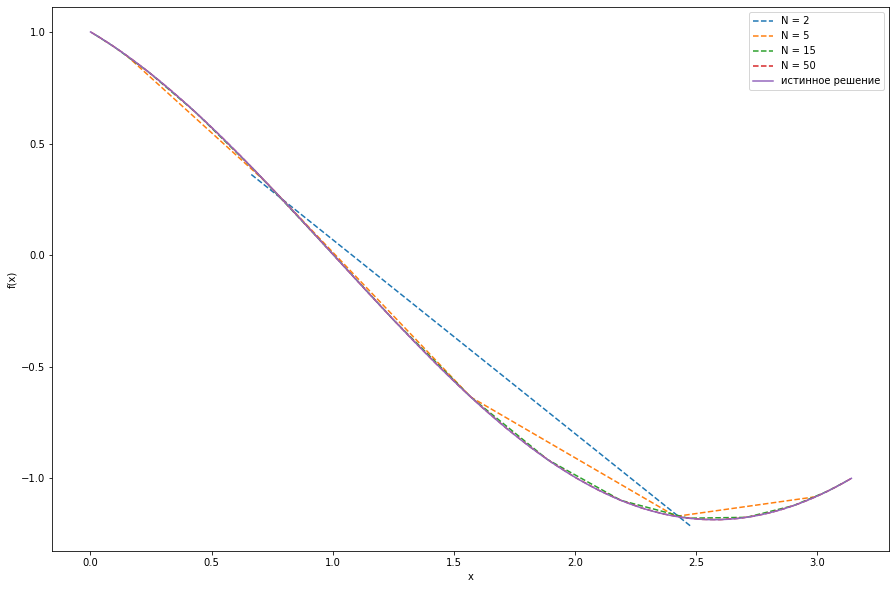

In [103]:
import matplotlib.pyplot as plt
from scipy.linalg import solve
from scipy.special import roots_sh_legendre

K = lambda x, t: np.sin(np.pi * x) * t
g = lambda x: np.cos(np.pi * x)

def foo(n):
    roots, weights = roots_sh_legendre(n)
    I = np.eye(n)
    A = np.pi / 2 * np.asarray([weights * K(i, roots) for i in roots]) - I
    b = - g(roots)
    f = solve(A, b)
    return f

plt.figure(figsize=(15, 10))

for n in [2, 5, 15, 50]:
    roots, weights = roots_sh_legendre(n)
    x = roots * np.pi
    f = foo(n)
    plt.plot(x, f, '--', label=f'N = {n}')

plt.xlabel('x')
plt.ylabel('f(x)')
func = lambda x: np.cos(x) - 2 / np.pi * np.sin(x)
x = np.linspace(0, np.pi, 100)
plt.plot(x, func(x), '-', label='Верное решение')
plt.legend()

Очевидной проблемой предыдущего результата для $f(x)$ является то, что он возвращает решения на фиксированном наборе точек. Мы не контролируем их расположение.

Оказывается, интерполяционные методы (мы обсудим их на следующих занятиях) работают не очень хорошо, в сравнении с следующим подходом:

Используйте изначальный вид, чтобы вычислить значение функции на всём интервале:

$$
f(x) = g(x) + \lambda \sum_j^N w_j\, K(x, t_j)\, f(t_j)
$$

Сравните эту интерполяцию с точным решением для разлиных $N$.
(выбирайте наглядный масштаб)

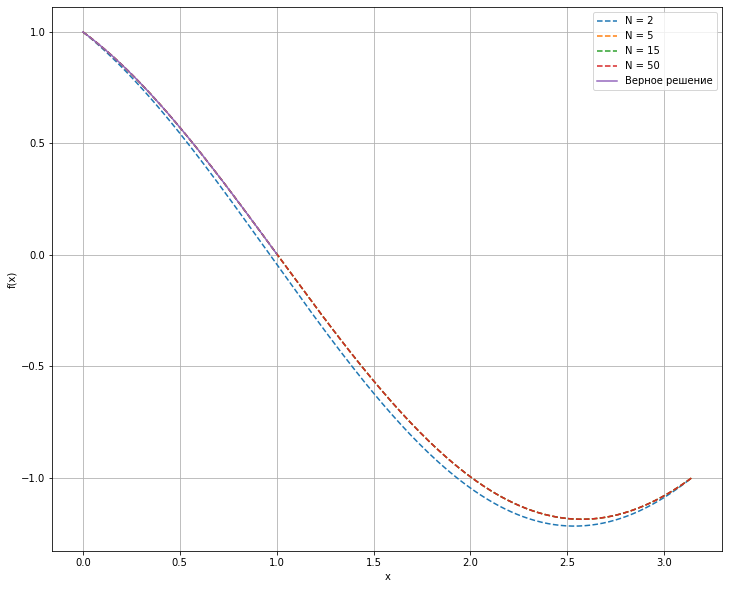

In [108]:
from numpy.lib.nanfunctions import nanargmin
x = np.linspace(0, 1, 200)

plt.figure(figsize=(12, 10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')

for n in [2, 5, 15, 50]:
    roots, weights = roots_sh_legendre(n)
    func = foo(n)
    f = lambda x: g(x) + np.pi / 2 * np.sum(weights * K(x, roots) * func)
    y = [f(i) for i in x]
    plt.plot(x * np.pi, y, '--', label=f'N = {n}')

func = lambda x: np.cos(x) - 2 / np.pi * np.sin(x)
plt.plot(x, func(x), '-', label='Верное решение')
plt.legend()

# Часть 3. Интеграл от осциллирующей функции - EXTRA points task

Рассмотрим определенный интеграл

$$
I = \int_0^\infty\! \frac{\sin(x) \cos{(\cos{(x)})}}{x}\,dx
$$

Вычислите значение данного интеграла с относительной точностью $10^{-6}$. Для упрощения задачи можете воспользоваться функционалом `scipy.integrate.quad`.

Заметим, что "из коробки" интеграл вычислить не удается, и нужно что-то придумать.

In [109]:
from math import sin, cos

from scipy.integrate import quad
quad(lambda x: sin(x) * cos(cos(x)) / x, 0, float('inf'))

<ipython-input-109-5a28b85f551f>:4: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad(lambda x: sin(x) * cos(cos(x)) / x, 0, float('inf'))


(1.9653912540956746, 4.089174284042278)

Напишите функцию, которая возвращает значение данного интеграла. Только само значение интеграла, без оценки погрешности.
(оборачиваем интеграл в функцию только для удобства автопроверки).

In [ ]:
from scipy.integrate import quad

def integ():
    """Return a single float, the computed value of the integral."""
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
from numpy.testing import assert_allclose

# this is a test cell, keep it intact
